### 1. Load Libraries

In [317]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import data

%matplotlib inline

### 2. Load Dataset

In [326]:
# Extract and retrieve rentals data from Microsoft SQL server
# Refer to documentation within data module for technical and configuration details
df_rentals = data.get_rentals()

df_rentals.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter
0,2012-07-02,23,clear,109.0,140.0,51.0,7.0,13,37,631
1,2011-12-22,10,cloudy,80.2,109.4,82.0,6.0,35,41,894
2,2011-02-25,11,clear,90.4,120.2,77.0,30.0,30,27,350
3,2012-03-10,1,clear,71.8,95.0,36.0,17.0,40,2,354
4,2011-06-19,5,cloudy,102.2,132.8,78.0,0.0,1,23,82


### 3. Data Insights <a id='data_insights'></a>

In [327]:
df_rentals.shape

(18643, 10)

- Dataset contains 18,643 observations with 10 features.


- There are 24 hours a day, 365 days a year. So over 2 years, there should be a maximum 17,520 (24 x 365 x 2) observations.


- Given that there are more hourly observations than hours over a 2 year period, some of the observations may be duplicates or erroneous. 


- The problem statement is to predict the total number of active e-scooter users given the above dataset.


- Each observation records the number of guest and registered users using rental e-scooters in a particular hour of a day.


- I shall assume that the total number of active e-scooter users in a particular hour of a day is the sum of the guest and registered users <i><b>i.e. active users = guest users + registered users.</b></i>

In [39]:
df_rentals.columns.values

array(['date', 'hr', 'weather', 'temperature', 'feels_like_temperature',
       'relative_humidity', 'windspeed', 'psi', 'guest_scooter',
       'registered_scooter'], dtype=object)

- Column labels of the rentals dataset

In [141]:
df_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18643 entries, 0 to 18642
Data columns (total 10 columns):
date                      18643 non-null object
hr                        18643 non-null int64
weather                   18643 non-null object
temperature               18643 non-null float64
feels_like_temperature    18643 non-null float64
relative_humidity         18643 non-null float64
windspeed                 18643 non-null float64
psi                       18643 non-null int64
guest_scooter             18643 non-null int64
registered_scooter        18643 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 1.4+ MB


- No column with null/missing value.

### 4. Summary Statistics

In [55]:
df_rentals.describe()

,hr,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter
count,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000
mean,11.537145,88.433037,117.313608,62.733251,12.741082,25.142198,106.388940,1074.471383
std,6.924281,16.252200,20.364081,19.315897,8.217008,14.442978,147.151664,1055.916934
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,13.000000,12.000000,240.000000
50%,12.000000,88.700000,118.400000,63.000000,13.000000,25.000000,50.000000,807.000000
75%,18.000000,102.200000,134.600000,78.000000,17.000000,38.000000,144.000000,1535.500000
max,23.000000,131.000000,179.600000,100.000000,57.000000,50.000000,1099.000000,6203.000000


- Large differnece in the 75th %tile and max values of columns <b>windspeed</b>, <b>guest_scooter</b>, <b>registered_scooter</b>
- This observation suggests that there are extreme values or outliers in these columns. 

### 5. Data Cleaning

#### 5.1 <b style="font-family:'Courier New'; font-size:18px">date</b> Column

In [142]:
# Check data type of the date column
df_rentals.dtypes['date']

dtype('O')

- Convert the <b style="font-family:'Courier New'; font-size:15px">date</b> column from <b style="font-family:'Courier New'; font-size:15px">string</b> to <b style="font-family:'Courier New'; font-size:15px">date</b> data type.


- Combine the <b style="font-family:'Courier New'; font-size:15px">date</b> and <b style="font-family:'Courier New'; font-size:15px">hr</b> columns to a <b style="font-family:'Courier New'; font-size:15px">datetime</b> column.
- This is to facilitate the use of datetime/timeseries operations when doing exploration and feature engineering later.

In [328]:
# Rename date column to date_str to indicate string data type
df_rentals.rename(columns={'date': 'date_str'}, inplace=True)

# Convert date column from string to datetime data type
# df_rentals['date'] = pd.to_datetime(df_rentals['date'])

# Verify column data type
# df_rentals.dtypes['date']

In [329]:
# Create datetime column by concatenating the date and hr columns
df_rentals['datetime'] = df_rentals.apply(lambda row: row.date_str + ' ' + str(row.hr), axis=1) + ':00'

# Convert datetime column from string to datetime data type
df_rentals.datetime = pd.to_datetime(df_rentals.datetime)

# Verify column data type
df_rentals.dtypes['datetime']

dtype('<M8[ns]')

#### 5.2 <b style="font-family:'Courier New'; font-size:18px">hr</b> Column

In [414]:
# Check data type of the hr column
df_rentals.dtypes['hr']

dtype('int64')

#### 5.3 <b style="font-family:'Courier New'; font-size:18px">weather</b> Column <a id='weather_column'></a>

In [330]:
df_rentals.weather.unique()

array(['clear', 'cloudy', 'light snow/rain', 'loudy', 'CLOUDY', 'CLEAR',
       'lear', 'LIGHT SNOW/RAIN', 'clar', 'heavy snow/rain', 'cludy',
       'liht snow/rain'], dtype=object)

- The <b>weather</b> column contains categorical data.
- The <b>weather</b> data is 'dirty', clean up is neccessary. 
- Mixed cases i.e. clear and CLEAR..
- Incorrect spelling e.g. lear, clar


- Correct values 'lear' and 'clar' to be 'clear'.
- Correct values 'cludy' and 'loudy' to be 'cloudy'.
- Correct value 'liht snow/rain' to be 'light snow/rain'.

In [331]:
# Standardized weather column to lower case characters
df_rentals.weather = df_rentals.weather.str.lower()

In [332]:
dict_weather = {

    # Replace incorrect values 'lear' and 'clar' with 'clear'
    'lear': 'clear',
    'clar': 'clear',

    # Replace incorrect values 'cludy' and 'loudy' with 'cloudy'
    'cludy': 'cloudy',
    'loudy': 'cloudy',

    # Replace incorrect value 'liht snow/rain' with 'light snow/rain'
    'liht snow/rain': 'light snow/rain'
}

# Replace incorrect values in weather column
df_rentals.replace({'weather': dict_weather}, inplace=True)

In [333]:
# Verify that the incorrect values have been replaced
df_rentals.weather.unique()

array(['clear', 'cloudy', 'light snow/rain', 'heavy snow/rain'],
      dtype=object)

- The <b>weather</b> column contains 4 unique categorical values i.e. clear, cloudy, light snow/rain and heavy snow/rain.


- One-hot encoding can be applied to the <b>weather</b> column later in feature engineering.

#### 5.3 <b style="font-family:'Courier New'; font-size:18px">temperature</b>, <b style="font-family:'Courier New'; font-size:18px">feels_like_temperature</b> Columns<a id='temperature_feels_like_temperature_columns'></a>

In [17]:
# Get the maximum and minimum temperature recorded
max(df_rentals.temperature), min(df_rentals.temperature)

(131.0, 48.1)

In [18]:
# Get maximum and minimum feels_like_temperature recorded
max(df_rentals.feels_like_temperature), min(df_rentals.feels_like_temperature)

(179.6, 60.8)

In [19]:
# Number of observations with temperatures above 120°F
len(df_rentals[df_rentals.temperature > 120])

240

- I shall assume that values from the <b>temperature</b> and <b>feels_like_temperature</b> columns are in fahrenheit.

- I shal assume that this dataset is gathered from a city/town since people are renting e-scooters and e-bikes.


- The maximum value of the <b>temperature</b> column is 131°F which is pretty close to the [highest temperature ever recorded](https://en.wikipedia.org/wiki/List_of_weather_records#Highest_temperatures_ever_recorded) of 134.1°F.


- According to [TripSavvy](https://www.tripsavvy.com/the-worlds-hottest-cities-4070053), some of the highest temperatures recorded in a city include Phoenix 122°F, Marrakech 120°F, Mecca 121.6°F, Kuwait City 126°F, Ahvaz 129°F and Timbuktu 120°F.


- There are 240 observations with temperatures above 120°F.  This dataset should be from a city known for its high temperatures. If otherwise, the temperatures in these observations need to be verified.


- 'Feels like' temperature is also known as the [heat index](https://en.wikipedia.org/wiki/Heat_index).  In short, it is a temperature reading that factors in a component of relative humidity.


- We can verify the values of the <b>feels_like_temperature</b> column using the heat index [formula](https://en.wikipedia.org/wiki/Heat_index#Formula).


- Without any geographical information on this dataset given, I shall assume that all temperature readings are accurate. 

#### 5.4 <b style="font-family:'Courier New'; font-size:18px">relative_humidity</b> Column

In [20]:
# Get the maximum and minimum values of relative humidity recorded
max(df_rentals.relative_humidity), min(df_rentals.relative_humidity)

(100.0, 0.0)

In [111]:
# Number of observations with 0 relative humidity
len(df_rentals[df_rentals.relative_humidity==0])

25

- [Relative humidity](https://en.wikipedia.org/wiki/Relative_humidity) (RH) is the actual amount of water vapor present in relation to the capacity that the air has at a particular temperature.  It is express as a percentage.


- A relative humidity reading of 0 implies [air devoid of water vapor](https://www.chicagotribune.com/news/ct-xpm-2011-12-16-ct-wea-1216-asktom-20111216-story.html). This is quite impossible given the climate conditions of a city/town, where I assume this dataset is gathered.  Values of 0 in the <b>relative_humidity</b> column need to be verified.


- Since there are only 25 observations with 0 relative humidity, I've decided to drop them.


- A relative humidity reading of 100 means that the air is totally saturated with water vapor and cannot hold any more, creating the possibility of rain.  So values of 100 in the <b>relative_humidity</b> column are valid.

In [112]:
# Number of observations in dataset
len(df_rentals)

18643

In [323]:
# Drop observations with relative humidity value of 0
df_rentals.drop(df_rentals[df_rentals.relative_humidity==0].index, inplace=True)

# Check number of observations left after dropping
len(df_rentals)

17009

#### 5.5 <b style="font-family:'Courier New'; font-size:18px">windspeed</b> Column


In [29]:
# Get the maximum and minimum values of the windspeed column
max(df_rentals.windspeed), min(df_rentals.windspeed)

(57.0, 0.0)

- No units were given for the <b>windspeed</b> column.


- Apparently, wind speed can be measured using a variety of [units](https://en.wikipedia.org/wiki/Wind_speed#Units) e.g. beaufort, knots, m/s, km/h, mph, depending on purpose, region or target audience.


- [Wind speed of 0](https://www.wral.com/weather/blogpost/1116592/) is possible and said to be calm.


- I'm unable to gauge if the maximum wind speed of 57 is valid. 57 m/s implies a hurricane, but 57 km/h is just a near gale.  


- As such, I shall assume that values in the <b>windspeed</b> column are valid.


#### 5.6 <b style="font-family:'Courier New'; font-size:18px">psi</b> Column

In [33]:
# Get the maximum and minimum values of the psi column
max(df_rentals.psi), min(df_rentals.psi)

(50, 0)

- The [Pollutant Standard Index (psi)](https://en.wikipedia.org/wiki/Pollutant_Standards_Index) is a measure of pollutants present in the air (0 to 400). 


- Values in the <b>psi</b> column are valid.

#### 5.7 <b style="font-family:'Courier New'; font-size:18px">guest_scooter</b>, <b style="font-family:'Courier New'; font-size:18px">registered_scooter</b> Columns

In [44]:
# Get the maximum and minimum values of the guest_scooter column
max(df_rentals.guest_scooter), min(df_rentals.guest_scooter)

(1099, -2)

In [45]:
# Get the maximum and minimum values of the registered_scooter column
max(df_rentals.registered_scooter), min(df_rentals.registered_scooter)

(6203, -2)

In [46]:
# Number of observations with a negative value in either the guest_scooter or registered_scooter columns
len(df_rentals[(df_rentals.guest_scooter<0) | (df_rentals.registered_scooter<0)])

658

- Values in the <b>guest_scooter</b> and <b>registered_scooter</b> columns indicate the number of guest and registered users renting e-scooters in a particular hour, of a particular date.


- As such, the values in the <b>guest_scooter</b> and <b>registered_scooter</b> columns should not be negative.


- There are 658 observations with a negative value in either the <b>guest_scooter</b> or <b>registered_scooter</b> columns.


- As there is no way of verifying these erroneous values, I shall set all negative values in the <b>guest_scooter</b> or <b>registered_scooter</b> columns to 0.

In [334]:
# Set all negative values in the guest_scooter column to 0
df_rentals.loc[df_rentals.guest_scooter < 0, 'guest_scooter'] = 0

# Set all negative values in the registered_scooter column to 0
df_rentals.loc[df_rentals.registered_scooter < 0, 'registered_scooter'] = 0

# Verify that there all negative values in the guest_scooter and registered_scooter columns have been set to 0
len(df_rentals[(df_rentals.guest_scooter<0) | (df_rentals.registered_scooter<0)])

0

#### 5.8 Duplicate Observations

In [335]:
# Number of observations in dataset
len(df_rentals)

18643

- As mentioned in Section 3. [Data Insights](#data_insights), there are more hourly observations than hours over 2 years from 2011 to 2012.


- There are 18,618 hourly observations versus 17,520 (24 x 365 x 2) hours in the years 2011 and 2012.


- Therefore, there are duplicate or erroneous observations in the dataset.

In [336]:
# Number of observations that are duplicates
len(df_rentals[df_rentals.duplicated()])

1612

- There are 1,609 duplicate observations in the dataset.

 
- I shall drop these duplicated observations.

In [337]:
# Drop duplicate observations
df_rentals.drop_duplicates(inplace=True)

# Verify that the duplicate observations have been removed
len(df_rentals), any(df_rentals.duplicated())

(17031, False)

In [338]:
# Verify that all 17,009 observations have unique datetime values
len(df_rentals.datetime.unique())

17031

### 6. Feature Engineering

#### 6.1 Target/Dependent Variable

- The target variable i.e. active e-scooter users, is numerical and discrete in nature.


- As mentioned in Section 3. [Data Insights](#data_insights), the target variable (active e-scooter users) will be the sum of the guest and registered e-scooter users.


- The <b>active_scooter</b> column should be created <b>AFTER</b> data cleaning as both the <b>guest_scooter</b> and <b>registered_scooter</b> columns contain errors.


- Creating the <b>active_scooter</b> column before data cleaning would have introduced those pre-existing errors into the target variable column.

In [339]:
# Create active_scooter column as target variable
df_rentals['active_scooter'] = df_rentals.guest_scooter + df_rentals.registered_scooter

In [340]:
df_rentals.columns

Index(['date_str', 'hr', 'weather', 'temperature', 'feels_like_temperature',
       'relative_humidity', 'windspeed', 'psi', 'guest_scooter',
       'registered_scooter', 'datetime', 'active_scooter'],
      dtype='object')

#### 6.2 One-Hot Encode the <b style="font-family:'Courier New'; font-size:18px">weather</b> Column

- As mentioned in Section 5.2 [<b>weather</b> column](#weather_column), the <b>weather</b> column contains categorical data with 4 unique values i.e. clear, cloudy, light snow/rain and heavy snow/rain.


- To facilitate further exploration and modelling later, I will one-hot encode the <b>weather</b> column.


- I did not choose to label encode as assigning a running number series to categories has the disadvantage that the numerical values can be misinterpreted by machine learning algorithms as having some sort of hierarchy/order in them.

In [341]:
# Create binary values for weather category columns
df_rentals = pd.get_dummies(df_rentals, columns=['weather'], prefix=['weather'])

df_rentals.head()

,date_str,hr,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter,datetime,active_scooter,weather_clear,weather_cloudy,weather_heavy snow/rain,weather_light snow/rain
0,2012-07-02,23,109.0,140.0,51.0,7.0,13,37,631,2012-07-02 23:00:00,668,1,0,0,0
1,2011-12-22,10,80.2,109.4,82.0,6.0,35,41,894,2011-12-22 10:00:00,935,0,1,0,0
2,2011-02-25,11,90.4,120.2,77.0,30.0,30,27,350,2011-02-25 11:00:00,377,1,0,0,0
3,2012-03-10,1,71.8,95.0,36.0,17.0,40,2,354,2012-03-10 01:00:00,356,1,0,0,0
4,2011-06-19,5,102.2,132.8,78.0,0.0,1,23,82,2011-06-19 05:00:00,105,0,1,0,0


#### 6.3 Day of the Week

- The day of the week will probably have an impact on the number of rentals.  There could be more rentals on work days (Mon-Fri) as people commute to work, but stay at home on weekends.


- I will create a new feature/variable based on the day of week.


- Since the day of the week is categorical in nature, I'll also one-hot encode it.

In [342]:
df_rentals['day_of_wk'] = df_rentals.apply(lambda row: row.datetime.strftime('%A'), axis=1)

# One-Hot encode the day_of_wk column
df_rentals = pd.get_dummies(df_rentals, columns=['day_of_wk'], prefix=['day_of_wk'])

df_rentals.head()

,date_str,hr,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter,datetime,...,weather_cloudy,weather_heavy snow/rain,weather_light snow/rain,day_of_wk_Friday,day_of_wk_Monday,day_of_wk_Saturday,day_of_wk_Sunday,day_of_wk_Thursday,day_of_wk_Tuesday,day_of_wk_Wednesday
0,2012-07-02,23,109.0,140.0,51.0,7.0,13,37,631,2012-07-02 23:00:00,...,0,0,0,0,1,0,0,0,0,0
1,2011-12-22,10,80.2,109.4,82.0,6.0,35,41,894,2011-12-22 10:00:00,...,1,0,0,0,0,0,0,1,0,0
2,2011-02-25,11,90.4,120.2,77.0,30.0,30,27,350,2011-02-25 11:00:00,...,0,0,0,1,0,0,0,0,0,0
3,2012-03-10,1,71.8,95.0,36.0,17.0,40,2,354,2012-03-10 01:00:00,...,0,0,0,0,0,1,0,0,0,0
4,2011-06-19,5,102.2,132.8,78.0,0.0,1,23,82,2011-06-19 05:00:00,...,1,0,0,0,0,0,1,0,0,0


### 7. Data Visualization

#### 7.1 Correlation

In [343]:
corr_cols = df_rentals.columns.to_list()

#corr_cols.remove('feels_like_temperature')
#corr_cols.remove('guest_scooter')
#corr_cols.remove('registered_scooter')

# Create new dataset with relevant features for visualization purposes
df_rentals_viz = df_rentals[corr_cols]

# Generate the correlation matrix between features of the rental dataset
corr_rentals = df_rentals_viz.corr()

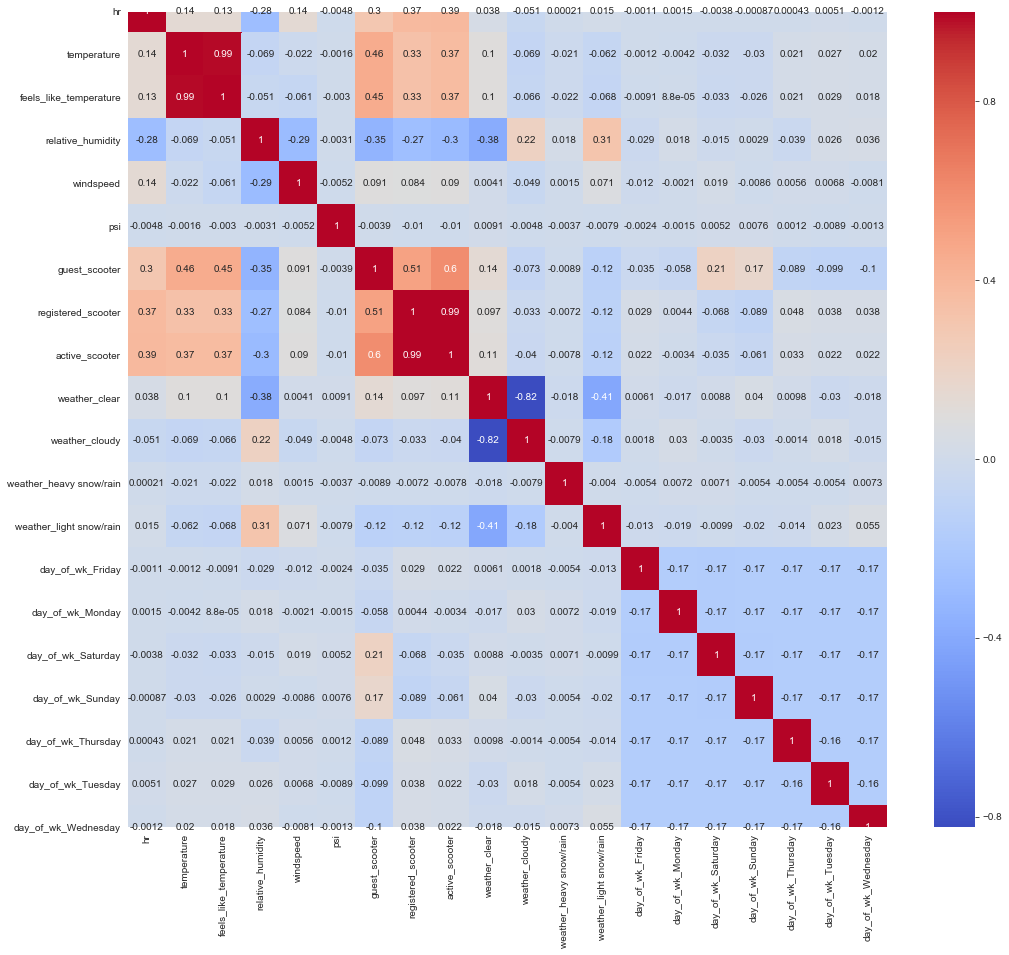

In [413]:
plt.figure(figsize=(17, 15))

# Display heat map of the correlation matrix
sns.heatmap(corr_rentals, cmap='coolwarm', annot=True) 

In [345]:
# Get the correlative coefficients of the target variable (active_scooter) 
corr_rentals['active_scooter'].sort_values(ascending=False)

active_scooter             1.000000
registered_scooter         0.993733
guest_scooter              0.599284
hr                         0.385749
temperature                0.370321
feels_like_temperature     0.367004
weather_clear              0.107738
windspeed                  0.089508
day_of_wk_Thursday         0.033076
day_of_wk_Tuesday          0.022435
day_of_wk_Friday           0.022335
day_of_wk_Wednesday        0.022110
day_of_wk_Monday          -0.003441
weather_heavy snow/rain   -0.007826
psi                       -0.010106
day_of_wk_Saturday        -0.035288
weather_cloudy            -0.039825
day_of_wk_Sunday          -0.060577
weather_light snow/rain   -0.122512
relative_humidity         -0.298918
Name: active_scooter, dtype: float64

- <b>registered_scooter</b> has strong positive correlation (> 0.99) to the target variable <b>active_scooter</b>.  


- This is expected as <b>active_scooter</b> is the sum of <b>registered_scooter</b> and <b>guest_scooter</b>. 


- <b>guest_scooter</b> also has a positive correlation but not as strongly as <b>registered_scooter</b>. 


- This is because <b>registered_scooter</b> is the bigger part of the summation, on average it contributes up to 90% of the value of <b>active_scooter</b>.


- Features most correlated to the target variable are <b>registered_scooter</b>, <b>guest_scooter</b>, <b>hr</b>, <b>temperature</b>, <b>feels_like_temperature</b> and <b>relative_humidity.</b>


- <b>temperature</b> and <b>feels_like_temperature</b> presents strong positive correlation (0.99).  This is probably because <b>feels_like_temperature</b>, also known as heat index (refer to Section 5.3 [temperature, feels_like_temperature Columns](#temperature_feels_like_temperature_columns), is derived from <b>temperature</b> and <b>relative_humidity</b>.


- <b>weather_clear</b> and <b>weather_light snow/rain</b> are the more significant weather conditions.


- <b>day_of_wk_Saturday</b> and <b>day_of_wk_Sunday</b> are the more significant days in the week.


- It is worth to note that apart from <b>registered_scooter</b>, most other features are not strongly correlated to the target variable.

In [315]:
# Create a dataset to compare guest, registered and total active users 
df_users = df_rentals_viz.loc[:, ['active_scooter', 'guest_scooter', 'registered_scooter']]

# Create a column that shows the percentage of registered users in the total active users
df_users['registered_scooter_%'] = df_users['registered_scooter'] / df_users['active_scooter'] * 100

# Get the mean (in %) of registered_scooter's contribution towards the active_scooter value
df_users['registered_scooter_%'].mean()

91.05239011532313

#### 7.2 Outliers

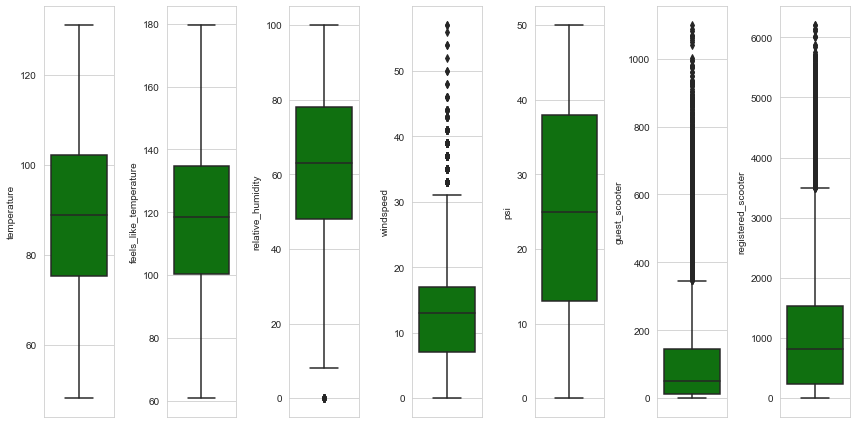

In [398]:
# Select columns with numerical data
ol_cols = ['temperature', 'feels_like_temperature', 'relative_humidity', 'windspeed', 'psi', 
           'guest_scooter', 'registered_scooter']

df_outliers = df_rentals_viz[ol_cols]

cols_count = len(ol_cols)

plt.figure(figsize=(12, 6))

# Generate box plots for all numerical independent variables  
for i in range(0, cols_count):
    
    plt.subplot(1, cols_count, i+1)
    
    sns.set_style('whitegrid')
    
    sns.boxplot(df_outliers[ol_cols[i]], color='green', orient='v')
    
    plt.tight_layout()

- Independent variables <b>windspeed</b>, <b>guest_scooter</b> and <b>registered_scooter</b> contain large numbers of outliers.


- Independent variables <b>temperature</b> and <b>feels_like_temperature</b> have similar distribution of values.

In [402]:
# Generate quantile and maximum values of numerical features

ser_quantile_1st = df_outliers.quantile(0.25)
ser_quantile_3rd = df_outliers.quantile(0.75)
ser_iqr = ser_quantile_3rd - ser_quantile_1st
ser_3iqr = ser_iqr * 1.5
ser_max = ser_quantile_3rd + ser_3iqr

df_boxplots = pd.DataFrame({'3rd': ser_quantile_3rd, '1st': ser_quantile_1st, 'iqr': ser_iqr, 
                            '3iqr': ser_3iqr, 'max': ser_max})
df_boxplots

,3rd,1st,iqr,3iqr,max
temperature,102.2,75.2,27.0,40.5,142.7
feels_like_temperature,134.6,100.4,34.2,51.3,185.9
relative_humidity,78.0,48.0,30.0,45.0,123.0
windspeed,17.0,7.0,10.0,15.0,32.0
psi,38.0,13.0,25.0,37.5,75.5
guest_scooter,145.0,11.0,134.0,201.0,346.0
registered_scooter,1540.0,240.0,1300.0,1950.0,3490.0


In [410]:
# Get number of outliers in the windspeed, guest_scooter, registered_scooter variables
len(df_outliers[df_outliers.windspeed>32]), len(df_outliers[df_outliers.guest_scooter>346]), len(df_outliers[df_outliers.registered_scooter>3490])

(330, 1147, 671)

#### 7.3 Distribution Skewness

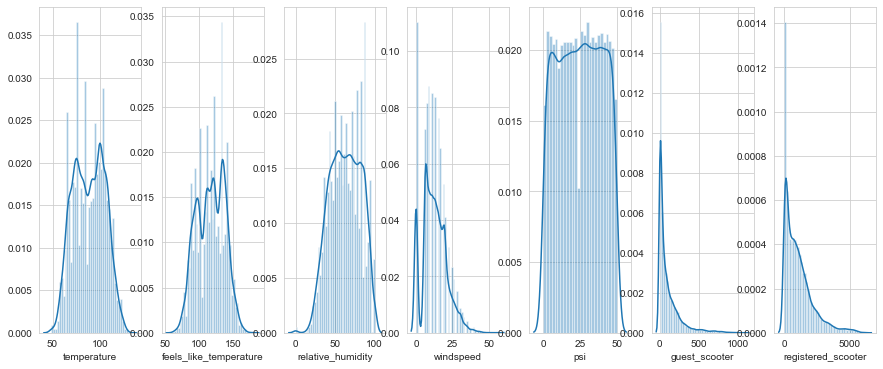

In [412]:
plt.figure(figsize=(15, 6))

# Generate distribution plots for all numerical independent variables  
for i in range(0, cols_count):
    
    plt.subplot(1, cols_count, i+1)
    
    sns.distplot(df_outliers[ol_cols[i]], kde=True) 

- Independent variables <b>windspeed</b>, <b>guest_scooter</b> and <b>registered_scooter</b> are right/positively skewed.


- Distribution plots of variables <b>temperature</b>, <b>feels_like_temperature</b> and <b>relative_humidity</b> are similar.

### 8. Feature Selection

In [298]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_cols = df_rentals_viz.columns.to_list()

X_cols.remove('active_scooter')
X_cols.remove('date_str')
X_cols.remove('datetime')
X_cols.remove('weather')

X_cols

['hr',
 'temperature',
 'feels_like_temperature',
 'relative_humidity',
 'windspeed',
 'psi',
 'guest_scooter',
 'registered_scooter',
 'day_of_wk_Friday',
 'day_of_wk_Monday',
 'day_of_wk_Saturday',
 'day_of_wk_Sunday',
 'day_of_wk_Thursday',
 'day_of_wk_Tuesday',
 'day_of_wk_Wednesday']

In [299]:
X =  df_rentals_viz.loc[:, X_cols]
y = df_rentals_viz.loc[:, 'active_scooter']

In [300]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [301]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)

,0,0
0,hr,3.392497e+04
1,temperature,1.811777e+04
2,feels_like_temperature,2.113250e+04
3,relative_humidity,3.282415e+04
4,windspeed,2.072732e+04
5,psi,3.125241e+04
6,guest_scooter,2.437521e+06
7,registered_scooter,1.759651e+07
8,day_of_wk_Friday,3.474049e+03
9,day_of_wk_Monday,3.123971e+03


In [302]:
featureScores.columns = ['Specs','Score']

print(featureScores.nlargest(10,'Score'))

                     Specs         Score
7       registered_scooter  1.759651e+07
6            guest_scooter  2.437521e+06
0                       hr  3.392497e+04
3        relative_humidity  3.282415e+04
5                      psi  3.125241e+04
2   feels_like_temperature  2.113250e+04
4                windspeed  2.072732e+04
1              temperature  1.811777e+04
12      day_of_wk_Thursday  3.520191e+03
8         day_of_wk_Friday  3.474049e+03
